In [9]:
import pandas as pd
sampled_data = pd.read_csv('race_dataset.csv')

In [10]:
import numpy as np

def calculate_confusion_matrix(y_true, y_pred, group):
    # Ensure that group is a boolean array for indexing
    group = group.astype(bool)

    # Filter the predictions and true values based on the group
    y_true_group = y_true[group]
    y_pred_group = y_pred[group]

    # Calculate true positives, false positives, true negatives, and false negatives
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    return tp, tn, fp, fn

def EqualOpportunityDifference(y, pred, group_a, group_b):
    tp_a, _, _, fn_a = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, _, fn_b = calculate_confusion_matrix(y, pred, group_b)
    tpr_a = tp_a / (tp_a + fn_a) if (tp_a + fn_a) > 0 else 0
    tpr_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    return tpr_b - tpr_a

def FalsePositiveRateBalance(y, pred, group_a, group_b):
    _, tn_a, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    _, tn_b, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    fpr_a = fp_a / (fp_a + tn_a) if (fp_a + tn_a) > 0 else 0
    fpr_b = fp_b / (fp_b + tn_b) if (fp_b + tn_b) > 0 else 0
    return fpr_b - fpr_a

def EqualisedOdds(y, pred, group_a, group_b):
    return (EqualOpportunityDifference(y, pred, group_a, group_b) +
            FalsePositiveRateBalance(y, pred, group_a, group_b)) / 2

def PredictiveParityDifference(y, pred, group_a, group_b):
    tp_a, _, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    precision_a = tp_a / (tp_a + fp_a) if (tp_a + fp_a) > 0 else 0
    precision_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
    return precision_b - precision_a

def StatisticalParityDifference(y, pred, group_a, group_b):
    positive_rate_a = pred[group_a].mean()
    positive_rate_b = pred[group_b].mean()
    return positive_rate_b - positive_rate_a


In [11]:
value_counts = sampled_data['derived_race'].value_counts()
print(value_counts)

2.0    244511
0.0     23032
1.0     18221
Name: derived_race, dtype: int64


In [12]:
# 2.0 = white
# 1.0 = black
# 0.0 = asian
group_a = (sampled_data['derived_race'] == 2.0).astype(int)
group_b = (sampled_data['derived_race'] != 2.0).astype(int)
group_c = (sampled_data['derived_race'] != 1.0).astype(int)
group_d = (sampled_data['derived_race'] == 1.0).astype(int)
group_g = (sampled_data['derived_race'] == 0.0).astype(int)
group_h = (sampled_data['derived_race'] == 1.0).astype(int)
group_i = (sampled_data['derived_race'] == 2.0).astype(int)
group_j = (sampled_data['derived_race'] == 0.0).astype(int)

bias_metrics = {
    "Equal Opportunity Difference": EqualOpportunityDifference,
    "False Positive Rate Balance": FalsePositiveRateBalance,
    "Equalised Odds": EqualisedOdds,
    "Predictive Parity Difference": PredictiveParityDifference,
    "Statistical Parity Difference": StatisticalParityDifference
}

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_auc_score

# setup the metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score,
                }
                


In [13]:
from sklearn.model_selection import train_test_split

y = sampled_data['action_taken']

X = sampled_data.drop(['Unnamed: 0','action_taken', 'derived_race','derived_sex'], axis=1)

test_set = 0.2
seed = 123

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set, random_state=seed, stratify=y)


In [14]:
X_train.columns

Index(['aus_1', 'applicant_credit_score_type', 'balloon_payment',
       'business_or_commercial_purpose', 'co_applicant_credit_score_type',
       'combined_loan_to_value_ratio', 'debt_to_income_ratio',
       'derived_dwelling_category', 'ffiec_msa_md_median_family_income',
       'hoepa_status', 'income', 'initially_payable_to_institution',
       'interest_only_payment', 'loan_amount', 'loan_purpose',
       'negative_amortization', 'occupancy_type', 'preapproval',
       'property_value', 'purchaser_type', 'total_units',
       'open_end_line_of_credit', 'tract_owner_occupied_units',
       'derived_msa_md', 'tract_median_age_of_housing_units',
       'tract_minority_population_percent', 'tract_one_to_four_family_homes',
       'tract_population', 'tract_to_msa_income_percentage'],
      dtype='object')

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd

lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none", max_iter=1000)
mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

white_metrics_all = pd.DataFrame()
black_metrics_all = pd.DataFrame()
asianblack_metrics_all = pd.DataFrame()
asianwhite_metrics_all = pd.DataFrame()
k, i = True, 1
i = 1
for (train, test) in mv.split(X, y):
    lr.fit(X.iloc[train], y.iloc[train].values.ravel())
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # Reset these lists inside the loop for each fold
    white_metrics = []
    black_metrics = []
    asianblack_metrics = []
    asianwhite_metrics = []

    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])


/Users/visharlya/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/visharlya/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [16]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.989864,0.000362
Accuracy,0.962189,0.000677
F1-Score,0.978805,0.000393
Precision,0.985243,0.000329
Recall,0.972451,0.001024


<Axes: title={'center': 'Value'}, xlabel='Metric'>

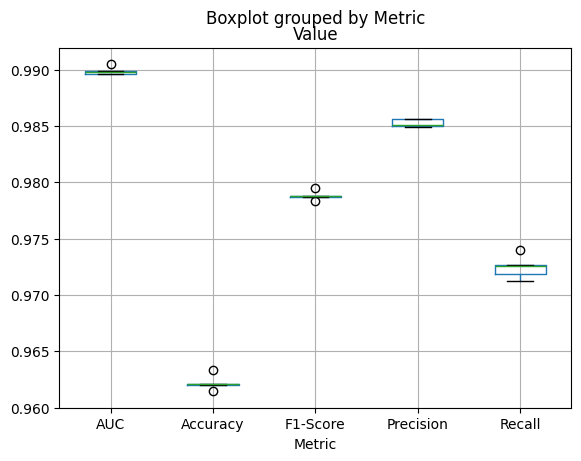

In [17]:
df_metrics.boxplot(column='Value', by='Metric')

In [18]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.024754,0.003168
Equalised Odds,-0.006702,0.005661
False Positive Rate Balance,0.011349,0.011721
Predictive Parity Difference,-0.010189,0.002238
Statistical Parity Difference,0.000000,0.000000


In [19]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006751,0.003673
Equalised Odds,-0.013613,0.007032
False Positive Rate Balance,-0.020476,0.012793
Predictive Parity Difference,-0.016488,0.002640
Statistical Parity Difference,0.000000,0.000000


In [20]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.034932,0.004945
Equalised Odds,0.014608,0.007213
False Positive Rate Balance,0.064147,0.012259
Predictive Parity Difference,-0.005417,0.002378
Statistical Parity Difference,0.000000,0.000000


In [21]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.025146,0.006307
Equalised Odds,-0.027191,0.010622
False Positive Rate Balance,-0.079528,0.015917
Predictive Parity Difference,-0.011528,0.002491
Statistical Parity Difference,0.000000,0.000000


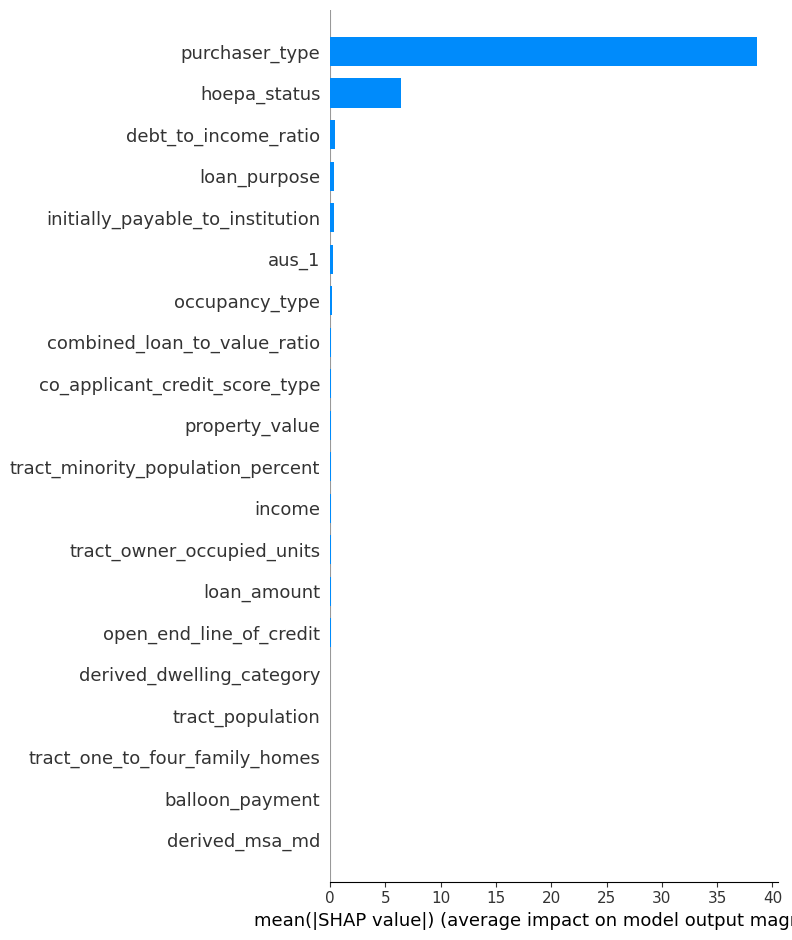

In [22]:
import shap
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [23]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    xgb_clf = xgb_clf.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = xgb_clf.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = xgb_clf.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [24]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.993213,0.000423
Accuracy,0.969258,0.000956
F1-Score,0.982882,0.000538
Precision,0.982716,0.000251
Recall,0.983049,0.000896


<Axes: title={'center': 'Value'}, xlabel='Metric'>

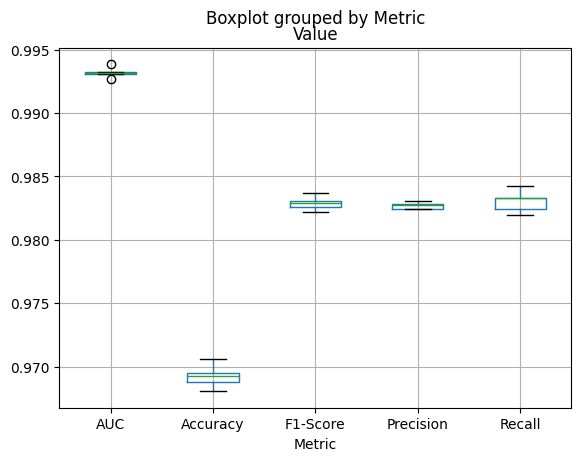

In [25]:
df_metrics.boxplot(column='Value', by='Metric')

In [26]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.017477,0.008062
Equalised Odds,-0.004798,0.005432
False Positive Rate Balance,0.007881,0.011039
Predictive Parity Difference,-0.010165,0.002039
Statistical Parity Difference,0.071151,0.224998


In [27]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006399,0.003033
Equalised Odds,-0.014777,0.005770
False Positive Rate Balance,-0.023154,0.011298
Predictive Parity Difference,-0.017673,0.002453
Statistical Parity Difference,0.087315,0.276113


In [28]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.021138,0.011332
Equalised Odds,0.020406,0.007568
False Positive Rate Balance,0.061949,0.014459
Predictive Parity Difference,-0.005039,0.002453
Statistical Parity Difference,0.030997,0.154987


In [29]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.012361,0.009359
Equalised Odds,-0.033806,0.009737
False Positive Rate Balance,-0.079974,0.014731
Predictive Parity Difference,-0.013626,0.002370
Statistical Parity Difference,0.000696,0.003478


100%|===================| 228569/228611 [08:03<00:00]       

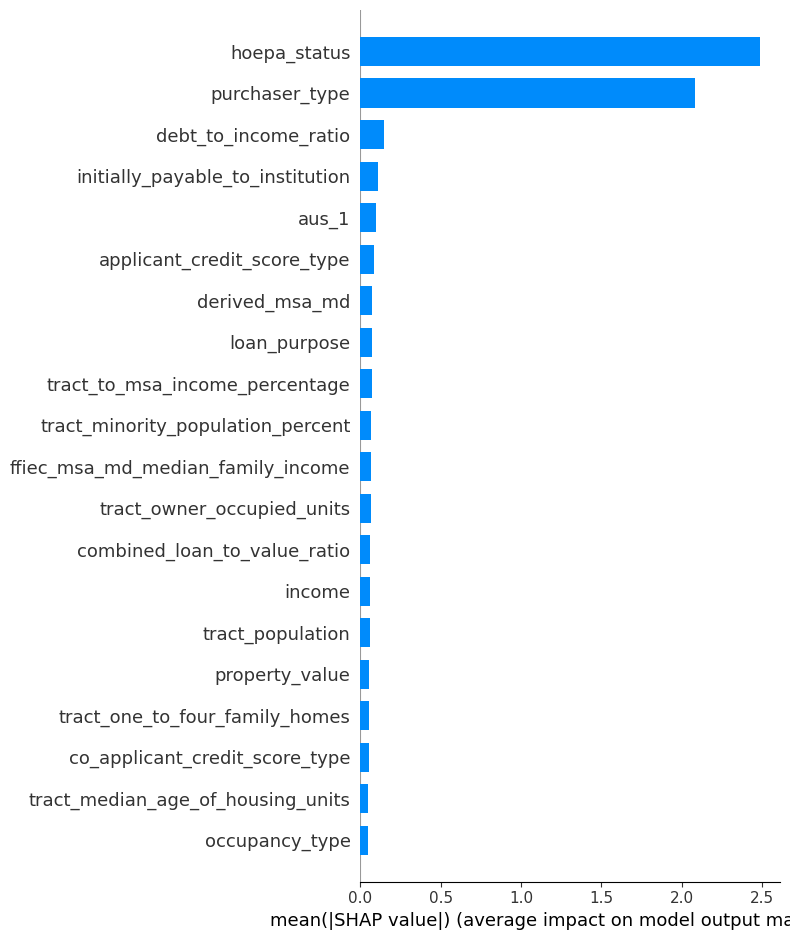

In [30]:

explainer = shap.TreeExplainer(xgb_clf, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [31]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    random_forest = random_forest.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = random_forest.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = random_forest.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [32]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.993227,0.000382
Accuracy,0.969391,0.001057
F1-Score,0.982949,0.000589
Precision,0.983215,0.000649
Recall,0.982683,0.000611


<Axes: title={'center': 'Value'}, xlabel='Metric'>

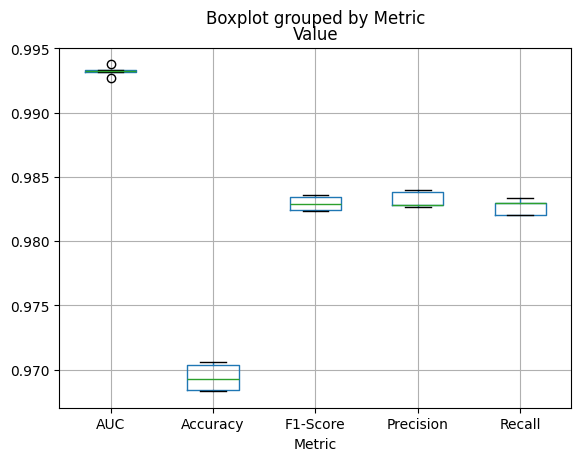

In [33]:
df_metrics.boxplot(column='Value', by='Metric')

In [34]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.014770,0.007602
Equalised Odds,-0.004076,0.005811
False Positive Rate Balance,0.006619,0.011960
Predictive Parity Difference,-0.010049,0.002170
Statistical Parity Difference,0.094867,0.250355


In [35]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006275,0.002925
Equalised Odds,-0.015179,0.006040
False Positive Rate Balance,-0.024083,0.012479
Predictive Parity Difference,-0.017823,0.002477
Statistical Parity Difference,0.116419,0.307230


In [36]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.016785,0.009402
Equalised Odds,0.021577,0.008170
False Positive Rate Balance,0.059938,0.016363
Predictive Parity Difference,-0.004650,0.002630
Statistical Parity Difference,0.077493,0.234159


In [37]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.008617,0.007742
Equalised Odds,-0.035280,0.009863
False Positive Rate Balance,-0.079177,0.017157
Predictive Parity Difference,-0.014237,0.002489
Statistical Parity Difference,0.001739,0.005255


In [ ]:
explainer = shap.TreeExplainer(random_forest, X_train)
shap_values = explainer.shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [39]:
import pandas as pd
k, i = True, 1

from sklearn import svm

svm = svm.SVC(random_state=10, probability=True)

for (train, test) in mv.split(X, y):
    svm = svm.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    ypred_prob = svm.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = svm.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [40]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.990054,0.000432
Accuracy,0.964362,0.000886
F1-Score,0.980100,0.000501
Precision,0.982725,0.000996
Recall,0.977491,0.001287


<Axes: title={'center': 'Value'}, xlabel='Metric'>

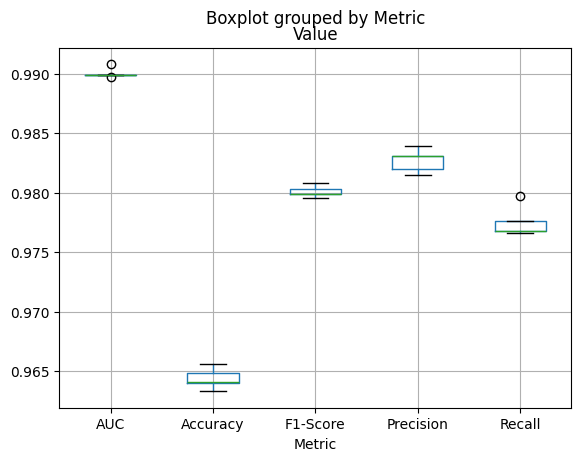

In [41]:
df_metrics.boxplot(column='Value', by='Metric')

In [42]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.013961,0.006717
Equalised Odds,-0.004496,0.005723
False Positive Rate Balance,0.004970,0.012040
Predictive Parity Difference,-0.009916,0.002120
Statistical Parity Difference,0.071151,0.218997


In [43]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006765,0.003198
Equalised Odds,-0.015926,0.005908
False Positive Rate Balance,-0.025086,0.011890
Predictive Parity Difference,-0.017961,0.002337
Statistical Parity Difference,0.087315,0.268748


In [44]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.015151,0.008029
Equalised Odds,0.021548,0.008507
False Positive Rate Balance,0.058246,0.017231
Predictive Parity Difference,-0.004400,0.002687
Statistical Parity Difference,0.094099,0.254021


In [45]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.007068,0.006837
Equalised Odds,-0.035639,0.010162
False Positive Rate Balance,-0.078346,0.018412
Predictive Parity Difference,-0.014414,0.002538
Statistical Parity Difference,0.002112,0.005701


In [ ]:

explainer = shap.LinearExplainer(svm, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [ ]:
import lightgbm as lgb
import numpy as np

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    train_data = lgb.Dataset(X.iloc[train],label=y.iloc[train])
    valid_data = lgb.Dataset(X.iloc[test],label=y.iloc[test], reference=train_data)

    lgb_model = lgb.train(parameters, train_data, valid_sets=[valid_data],num_boost_round=5000)

    # get predictions in the test set
    ypred_prob = lgb_model.predict(X.iloc[test]) # get probabilities
    ypred_class = (ypred_prob >= 0.5).astype(int)
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [ ]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


In [ ]:
df_metrics.boxplot(column='Value', by='Metric')

In [ ]:
print("WHITE/NOT WHITE:")
white_summary

In [ ]:
print("\nBLACK/NOT BLACK:")
black_summary

In [ ]:
print("\nASIAN/WHITE:")
asianwhite_summary

In [ ]:
print("\ASIAN/BLACK:")
asianblack_summary

In [ ]:

explainer = shap.LinearExplainer(lgb_model, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

